# Обучение лучшей модели

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

## Создание датасетов и разделение данных

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
class PermAppartmentDataset(Dataset):
    def __init__(self, filename):
        super().__init__()
        data = pd.read_csv(filename, sep=';')
        self.y = torch.from_numpy(data.price.values).to(dtype=torch.float32)
        self.x = torch.from_numpy(data.drop('price', axis=1).values).to(dtype=torch.float32)
        self.n = len(self.y)
        del data
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
test_set = PermAppartmentDataset('../final_test.csv')
valid_set = PermAppartmentDataset('../final_valid.csv')
train_set = PermAppartmentDataset('../final_train.csv')

# Загрузчики данных

In [12]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Составление модели

In [37]:
def train_loop(n_epoch, loss, optimizer, train_dl, val_dl, train_size, valid_size, every_n_epoch_print=1000):
    global model
    train_losses = []
    valid_losses = []
    for epoch in range(n_epoch):
        #   Считаем ошибку на тестовой выборке
        train_loss = 0
        val_loss = 0
        model.eval()
        with torch.no_grad():
            #   Считаем ошибку на обучающей выборке
            for i, (X, y) in enumerate(train_dl):
                y_pred = model(X)
                l = loss(y_pred, y.reshape(-1, 1))
                train_loss += l.item() * len(y)
            #   Считаем ошибку на тестовой выборке
            for i, (X, y) in enumerate(val_dl):
                y_pred = model(X)
                l = loss(y_pred, y.reshape(-1, 1))
                val_loss += l.item() * len(y)
        model.train()
        if np.sqrt(train_loss / train_size) < 365000:
            print('stop')
            break
        train_losses.append(np.sqrt(train_loss / train_size))
        valid_losses.append(np.sqrt(val_loss / valid_size))
        if epoch%every_n_epoch_print == 0:
            print(epoch, "/", n_epoch, " : ", 
                  " train loss = ", np.sqrt(train_loss / train_size),
                  " val loss = ", np.sqrt(val_loss / valid_size))

        # Бежим по пакетам (batches)
        for i, (X, y) in enumerate(train_dl):
            # Предсказание
            y_pred = model(X)
            l = loss(y_pred, y.reshape(-1, 1))
            # Расчёт градиентов
            l.backward()
            # Оптимизация
            optimizer.step()
            # Зануляем градиент
            optimizer.zero_grad()
    return np.array(train_losses), np.array(valid_losses)

In [6]:
def evaluate_on_test(loss, test_dl, test_size):
    global model
    predicts = []
    reals = []
    test_loss = 0
    model.eval()
    with torch.no_grad():
        #   Считаем ошибку на тестовой выборке
        for i, (X, y) in enumerate(test_dl):
            y_pred = model(X)
            for real, predict in zip(y.reshape(-1), y_pred.reshape(-1)):
                real_value = real.item()
                predict_value = predict.item()
                predicts.append(predict_value)
                reals.append(real_value)
            l = loss(y_pred, y.reshape(-1, 1))
            test_loss += l.item() * len(y)
    model.train()
    
    print("test loss = ", np.sqrt(test_loss / test_size))
    return np.array(reals), np.array(predicts)

## Лучшая модель

In [7]:
import torch.nn as nn

In [8]:
class BestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.BatchNorm1d(37),
            nn.Linear(37, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        res = self.seq(x)
        return res

In [9]:
model = BestModel()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0000000001, weight_decay=0.01)

In [66]:
train_losses, valid_losses = train_loop(
    n_epoch = 1001,
    every_n_epoch_print=50,
    loss = loss, 
    optimizer = optimizer,
    train_dl = train_loader, 
    val_dl = valid_loader, 
    train_size = len(train_set), 
    valid_size = len(valid_set)
)

0 / 1001  :   train loss =  3879238.27396564  val loss =  3724483.8778579533
50 / 1001  :   train loss =  3879297.377976754  val loss =  3724550.451911833
100 / 1001  :   train loss =  403319.39082703495  val loss =  382561.56209896866
150 / 1001  :   train loss =  400952.4515100131  val loss =  387270.7040764216
200 / 1001  :   train loss =  401557.65788567305  val loss =  354866.48321782844
250 / 1001  :   train loss =  396805.81703168736  val loss =  376442.63239448797
300 / 1001  :   train loss =  402127.10120035644  val loss =  358297.6666990943
350 / 1001  :   train loss =  404495.0958749755  val loss =  363493.7639387382
400 / 1001  :   train loss =  394604.1174422578  val loss =  372260.16250724933
450 / 1001  :   train loss =  396894.27859718056  val loss =  369854.0987390519
500 / 1001  :   train loss =  395470.6677537414  val loss =  374773.7785282829
550 / 1001  :   train loss =  394951.44037670497  val loss =  363160.31542149285
600 / 1001  :   train loss =  393707.2912547

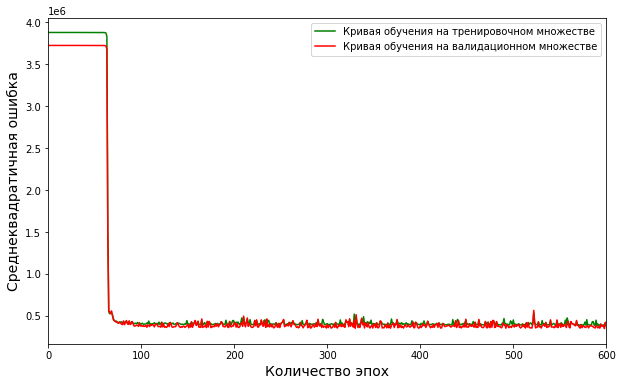

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(train_losses)), train_losses, c='g', label='Кривая обучения на тренировочном множестве')
plt.plot(np.arange(len(train_losses)), valid_losses, c='r', label='Кривая обучения на валидационном множестве')
plt.xlabel("Количество эпох", size=14)
plt.ylabel("Среднеквадратичная ошибка", size=14)
plt.xlim(0, 600)
plt.legend()

## Прогноз на тестовой выборке

In [13]:
reals1, predicts1 = evaluate_on_test(
    loss = loss, 
    test_dl = test_loader, 
    test_size = len(test_set), 
)

test loss =  333518.3367152591


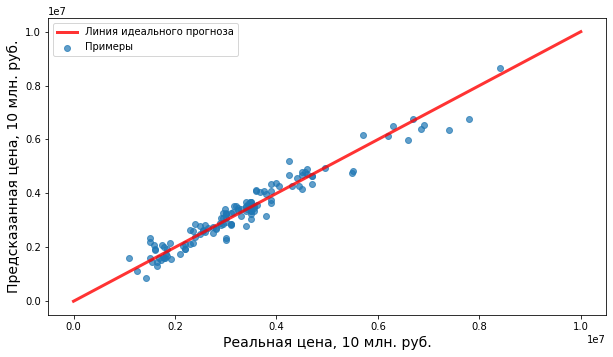

In [14]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot([0, 10_000_000], [0, 10_000_000], c='r', lw=3, alpha=0.8, label='Линия идеального прогноза')
plt.scatter(reals1, predicts1, alpha=0.7, label='Примеры')
plt.xlabel("Реальная цена, 10 млн. руб.", size=14)
plt.ylabel("Предсказанная цена, 10 млн. руб.", size=14)
plt.legend()

## Прогноз на тренировочной выборке

In [15]:
reals2, predicts2 = evaluate_on_test(
    loss = loss, 
    test_dl = train_loader, 
    test_size = len(train_set), 
)

test loss =  369532.16578698816


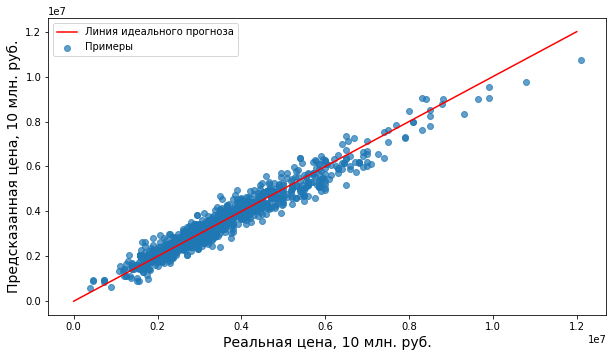

In [16]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot([0, 12_000_000], [0, 12_000_000], c='r', label='Линия идеального прогноза')
plt.scatter(reals2, predicts2, alpha=0.7, label='Примеры')
plt.xlabel("Реальная цена, 10 млн. руб.", size=14)
plt.ylabel("Предсказанная цена, 10 млн. руб.", size=14)
plt.legend()

## Оценка качества модели

## Коэффициент детерминации

In [17]:
from sklearn.metrics import r2_score

## Тестовая

In [18]:
r2_score(reals1, predicts1)

0.9431406587091239

## Тренировочная

In [19]:
r2_score(reals2, predicts2)

0.9406262895607053

## Среднеквадратичная относительная погрешность

In [20]:
def appartment_mean_square_error(reals, predicts):
    mean_square = np.mean((reals - predicts)**2)
    min_real = np.min(reals)
    max_real = np.max(reals)
    return np.sqrt(mean_square)/np.abs(max_real-min_real)*100

## Тестовая

In [21]:
appartment_mean_square_error(reals1, predicts1)

4.568744332820928

## Тренировочная

In [22]:
appartment_mean_square_error(reals2, predicts2)

3.1583945764030363

## Адекватность модели

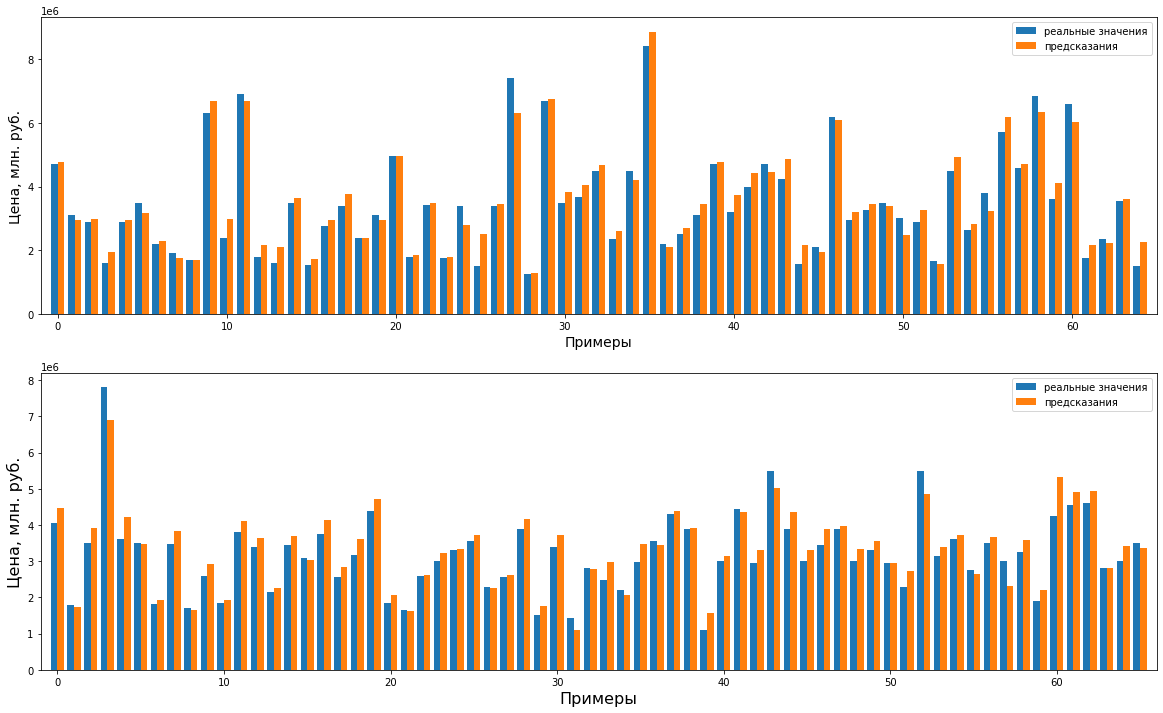

In [54]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
x1 = (np.array(range(len(reals)//2))-0.2)
x2 = (np.array(range(len(reals)//2))+0.2)
plt.bar(x1, reals[:len(reals)//2], width = 0.4, label='реальные значения')
plt.bar(x2, predicts[:len(reals)//2], width = 0.4, label='предсказания')
plt.xlabel("Примеры", size=14)
plt.ylabel("Цена, млн. руб.", size=14)
plt.xlim(-1, len(reals)//2)
plt.legend()
plt.subplot(2, 1, 2)
x1 = (np.array(range(len(reals)//2+1))-0.2)
x2 = (np.array(range(len(reals)//2+1))+0.2)
plt.bar(x1, reals[len(reals)//2:], width = 0.4, label='реальные значения')
plt.bar(x2, predicts[len(reals)//2:], width = 0.4, label='предсказания')
plt.xlabel("Примеры", size=16)
plt.ylabel("Цена, млн. руб.", size=16)
plt.xlim(-1, len(reals)//2+1)
plt.legend()

## Оценка значимости параметров

In [23]:
def evauate_feature_importance(model_, dataset_, names_):
    importances = []
    not_normed_importances = []
    standart_loss = 0
    sum_feature_loss = 0
    
    model.eval()
    with torch.no_grad():
        for (X, y) in dataset_:
            y_pred = model(X.reshape(1, -1))
            standart_loss += (y.item() - y_pred.item())**2
        standart_loss /= len(dataset_)
        
        list_np_arrays = []
        for (X, _) in dataset_:
            list_np_arrays.append(np.array(X))
        list_np_arrays = np.array(list_np_arrays)
        median_features = np.median(list_np_arrays, axis=0)

        for idx in range(len(names_)):
            feature_loss = 0
            for (X, y) in dataset_:
                data = X.clone().detach().requires_grad_(False)
                data[idx] = torch.tensor(median_features[idx], dtype=torch.float32)
                y_pred = model_(data.reshape(1, -1))
                feature_loss += (y.item() - y_pred.item())**2
            feature_loss /= len(dataset_)
            
            feature_importance = abs(standart_loss - feature_loss)
            sum_feature_loss += feature_importance
            not_normed_importances.append(feature_importance)
    model.train()
    for name, feature_importance in zip(names_, not_normed_importances):
        importances.append((feature_importance/sum_feature_loss, name))
    
    return importances

In [24]:
headers = [
        'Число комнат', 'Площадь', 'Число этажей',
       'Этаж квартиры', 'Год постройки', 'Число лифтов',
       'Наличие консьержа', 'Наличие мусоропровода', 'Дизайнерский ремонт', 'Евро-ремонт',
       'Косметический ремонт', 'Требуется ремонт', 'Несколько ванных комнат',
       'Раздельный санузел', 'Совмещенный санузел', 'Балкон',
       'Лоджия', 'Нет ни балкона, ни лоджии', 'Блочный дом',
       'Деревянный дом', 'Кирпичный дом',
       'Монолитный дом', 'Панельный дом',
       'Дзержинский район', 'Индустриальный район', 'Кировский район',
       'Ленинский район', 'Мотовилихинский район',
       'Орджоникидзевский район', 'Свердловский район', 'Широта', 'Долгота',
       'Число образовательных учреждений', 'Число заведений здоровья', 
       'Число заведений культуры', 'Число заведений общепита', 'Расстояние до центра'
]

In [25]:
test_importances = sorted(evauate_feature_importance(model, test_set, headers), key=lambda x: x[0], reverse=True)[:11]

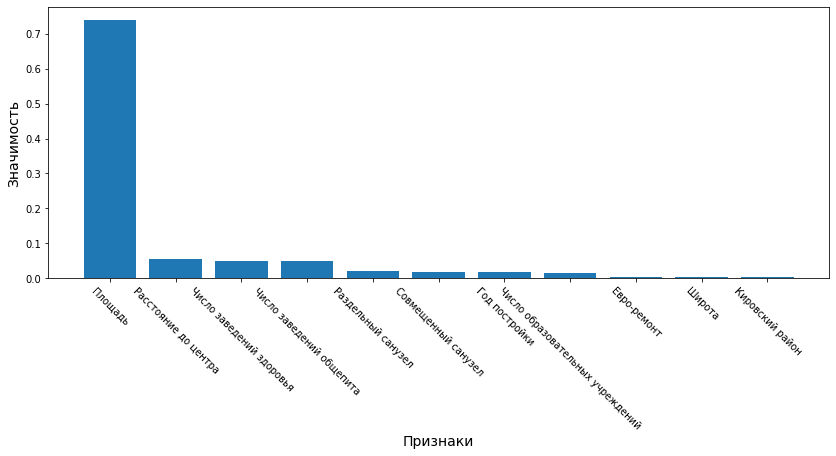

In [27]:
plt.figure(figsize=(14, 5))
labels = [item[1] for item in test_importances]
importances = [item[0] for item in test_importances]
plt.bar(labels, importances, width=0.8)
plt.xlabel("Признаки", size=14)
plt.ylabel("Значимость", size=14)
plt.xticks(rotation = -45)
plt.show()

In [26]:
train_importances = sorted(evauate_feature_importance(model, train_set, headers), key=lambda x: x[0], reverse=True)[:11]

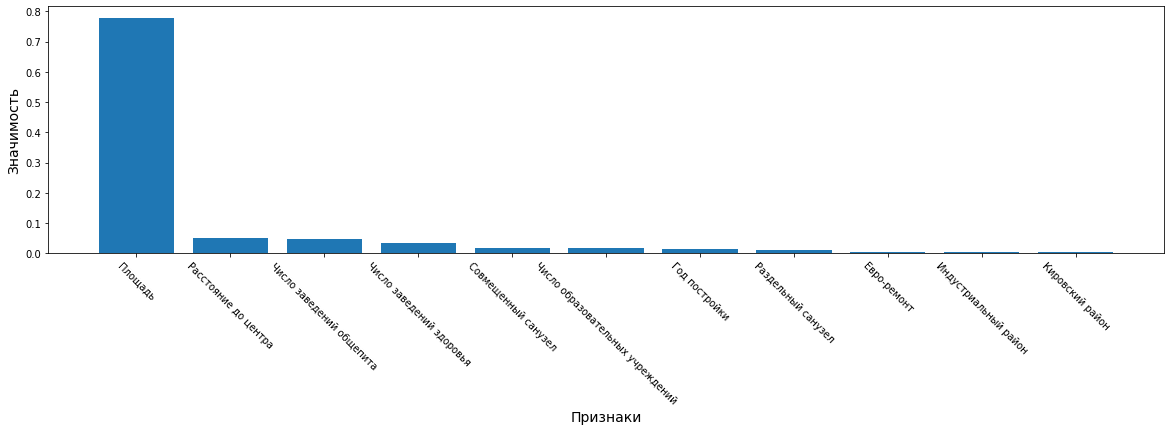

In [28]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
labels = [item[1] for item in train_importances]
importances = [item[0] for item in train_importances]
plt.bar(labels, importances)
plt.xlabel("Признаки", size=14)
plt.ylabel("Значимость", size=14)
plt.xticks(rotation = -45)
plt.show()

## Сохранение модели

In [205]:
torch.save(model.state_dict(), '../best_model.pkl')

In [10]:
model = BestModel()
model.load_state_dict(torch.load('../best_model.pkl'))

<All keys matched successfully>